In [1]:
from transformers import GPT2LMHeadModel

c:\Users\aatus\ohjelmointi\NeoGPT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
for k, v in model.state_dict().items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
from transformers import pipeline, set_seed


generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [14]:
from GPT2 import GPT2, Config

import torch
import torch.nn.functional as F
import tiktoken

# model = GPT2.from_pretrained("gpt2")
model = GPT2(Config())
model.eval()

num_return_sequences = 5
max_length = 30

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        logits, _ = model(x)  # logits, loss
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        highest_probs, indicies = torch.topk(probs, 50)
        index = torch.multinomial(highest_probs, 1)
        xcol = torch.gather(indicies, -1, index)
        x = torch.cat((x, xcol), dim=1)

In [15]:
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    print("> ", tokenizer.decode(tokens))

>  Hello, I'm a language model, Blacks Blacks Blackstxtbg Blacksclude ideologies unsigned unsigned Colleg blamed unquestion unquestion unquestionashes Tyson vessel protectionivilonduct Stupid
>  Hello, I'm a language model,ashes Üidentallyidentallyidentally Constitution Morocco engaging exceeding exceeding Bil Bil Politico gaping gaping recommendographicsographics sinful grav grav ($
>  Hello, I'm a language model, Indo Indo IndoWASHINGTON Fathers MicrosoftズarinWASHINGTON WAS pengu Mavericksanimalanimalammersammers adverscrete Mariaesity stylish vessel
>  Hello, I'm a language model,inisinisinis vessel accustomed accustomed groom groom groom groom groom Constitutionarin unquestion unquestion unquestion unquestioncrete Patelcrete unsignedplete
>  Hello, I'm a language model, Stuart FathersSQL groom recommend recommend Benson ideologies ideologies ideologiescreteratch Georg shirt vesselflower empathy capabilities groom agreeable agreeablemeier


In [11]:
import numpy as np

tokens = np.load("./edu_fineweb10B/edufineweb_train_000001.npy")
print(tokens.shape)
tokens = np.load("./edu_fineweb10B/edufineweb_val_000000.npy")
print(tokens.shape)

(100000000,)
(100000000,)


In [17]:
import os


log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
checkpoint_files = [f for f in os.listdir(log_dir) if f.startswith("model_") and f.endswith(".pt")]
assert len(checkpoint_files) > 0, "no checkpoints found to resume training from"
checkpoint_files = sorted(checkpoint_files)
checkpoint_file = checkpoint_files[-1]
checkpoint_path = os.path.join(log_dir, checkpoint_file)
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# load the model state
model = GPT2(checkpoint['config'])
model.to(device)
model.load_state_dict(checkpoint['model'])


tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        highest_probs, indicies = torch.topk(probs, 50)
        index = torch.multinomial(highest_probs, 1)
        xcol = torch.gather(indicies, -1, index)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    print("> ", tokenizer.decode(tokens))

>  Hello, I'm a language model, and I'm sure it will get over the edge, depending on the context we're working on. If the
>  Hello, I'm a language model, and I'm not an academic, I'm a programmer.’
In today's article, I'm
>  Hello, I'm a language model, but I'm aware that when I say something I'm describing in a way that you know the way I say
>  Hello, I'm a language model, because I'm learning Java.
So, what do we have in our code? It is an abstraction of
>  Hello, I'm a language model, so you haven't heard of languages from the past century to the present. And not all languages were created equally


Min Train Loss: 3.092686
Min Validation Loss: 3.2538
Max Hellaswag eval: 0.2847


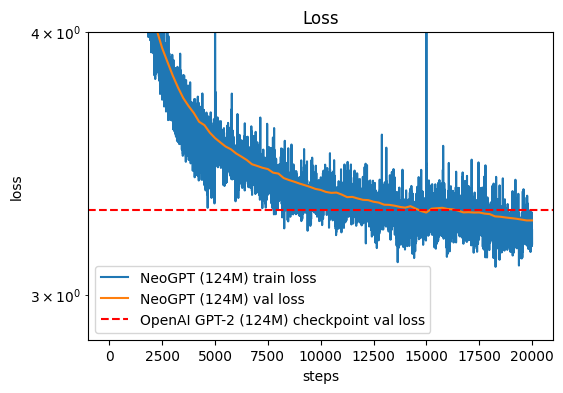

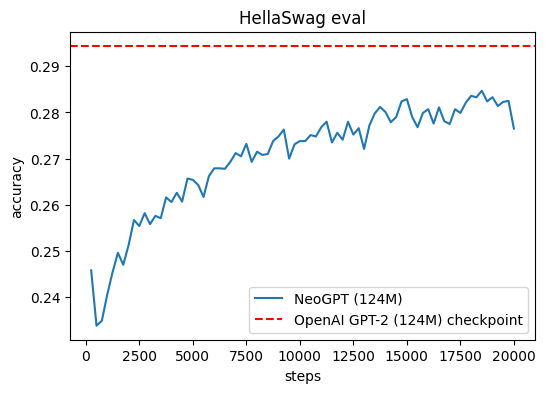

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]

with open("log/log.txt", "r") as f:
    lines = f.readlines()

streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

streams_xy = {}
for k, v in streams.items():
    xy = sorted(list(v.items()))
    streams_xy[k] = list(zip(*xy))


plt.figure(figsize=(6, 4))
xs, ys = streams_xy["train"]
ys = np.array(ys)
plt.plot(xs, ys, label=f'NeoGPT ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"]
plt.plot(xs, ys, label=f'NeoGPT ({sz}) val loss')
plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

plt.figure(figsize=(6, 4))
xs, ys = streams_xy["hella"]
ys = np.array(ys)
plt.plot(xs, ys, label=f"NeoGPT ({sz})")
plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))